In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_tests5

In [2]:
class OLS_loglike(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(OLS_loglike,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        mu_y = np.matmul(x,params)  
        resid = y - mu_y
        sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
        pr_y = stats.norm.logpdf( resid, loc=0,scale=sigma )
        return pr_y

In [3]:
def gen_data(nobs=1000, a=1.00, num_params=4):
    x = np.random.normal(scale=1., size=(nobs,num_params))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + a*x.sum(axis=1) + e
    return y,x,nobs

In [4]:
def setup_model(yn,xn):
    """setup models for ease"""
    model1 = sm.OLS(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    params1 = (model1_fit.params)
    model1_deriv = OLS_loglike(yn,sm.add_constant(xn))
    ll1 = model1_deriv.loglikeobs(model1_fit.params)
    
    return ll1


def setup_test(yn,xn):
    lls = []
    grads = []
    hesss = []
    params = []                
    for i in range(xn.shape[1]):
        ll = setup_model(yn,xn[:,i])
        lls.append(ll)
    
    return np.array(lls)

def compute_test_stat(lls):
    k = lls.shape[0]
    n = lls.shape[1]
    
    #setup stuff..
    theta = lls.mean(axis=1).reshape((k,1)) 
    V = np.cov(lls)
    
    # linear restrictions
    R = np.identity(k-1)
    R = np.concatenate( (-1*np.ones( (k-1,1) ),R),axis=1 )
    
    #compute the wald statistic
    Rtheta = R.dot(theta)
    RVR_inv = np.linalg.inv(R.dot(V).dot(R.transpose())/n)
    return (Rtheta.transpose()).dot(RVR_inv).dot(Rtheta)[0,0]
    
    
yn,xn,nobs = gen_data(nobs=1000, a=1.0, num_params=4)
lls = setup_test(yn,xn)
compute_test_stat(lls)

2.6478029333333626

In [27]:
def order_lls(lls):
    k = lls.shape[0]
    means = lls.mean(axis=1).reshape((k,1)) 
    return lls[means[:, 0].argsort()]


def recursive_test(lls):
    """lls must be ordered for this to work"""
    test_stat = compute_test_stat(lls)
    critical_value = stats.chi2.ppf(.95,lls.shape[0]-1)
    reject_null = test_stat >= critical_value

    result  = [(reject_null, lls.shape[0])]
    if reject_null and lls.shape[0] > 2 :
        stat1 = recursive_test(lls[0:-1,:])
        stat2 = recursive_test(lls[1:,:])
        result.append(stat1)
        result.append(stat2)
    return result


def gen_data_new(nobs=1000, a=1.0, num_params=4):
    x = np.random.normal(scale=1., size=(nobs,num_params))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + 2*x[:,0] + a*x[:,1:].sum(axis=1) + e
    return y,x,nobs


def parse_result(result):
    level = 0
    if len(result) == 1:
        pass
    if len(result) == 2:
        stat1 = parse_result(result[1])
        level = level + 1 + stat1
    if len(result) == 3:
        stat1 = parse_result(result[1])
        stat2 = parse_result(result[1])
        level = level + 1 + max(stat1,stat2)
    return level
    

def monte_carlo(k=4,trials=10):
    #check size of first test...
    rejects = np.array([0]*(k-1))
    # the index in the array refers to the stage when the test gets cut off
    for i in range(trials):
        yn,xn,nobs = gen_data_new(nobs=500, a=1.0, num_params=k)
        lls = setup_test(yn,xn)
        lls_ordered = order_lls(lls)
        test_result = recursive_test(lls_ordered)
        stop_point = parse_result(test_result)
        rejects[stop_point] = rejects[stop_point] +1
        
    return rejects/trials


print(monte_carlo(trials=100,k=5))

[0.   0.96 0.04 0.  ]


In [6]:
def plot_true2(gen_data,setup_test,trials=500):
    
    llr_stats = []
    num_params=0
    for i in range(trials):
        yn, xn,nobs = gen_data()
        llrs = setup_test(yn,xn)
        llr = compute_test_stat(llrs)
        llr_stats.append(llr)
        num_params = xn.shape[1]
    
    plt.hist(llr_stats, density=True,bins=15, label="True",alpha=.60)
    #chi sq
    chi_sq = np.random.normal(loc=0.0, scale=1.0, size=(num_params-1,1000))
    chi_sq = (chi_sq**2).sum(axis=0)
    plt.hist(chi_sq, density=True,bins=15, label=("Chi-sq %s"%(num_params-1)),alpha=.60)
    
    #draw plot with actual cdf?
    x = np.linspace(stats.chi2.ppf(0.01, num_params-1), stats.chi2.ppf(0.995, num_params-1), 100)
    plt.plot(x, stats.chi2.pdf(x, num_params-1), 'r-', lw=5, alpha=0.6, label='chi2 pdf')
    
    plt.legend()
    plt.savefig('k' + str(num_params) +'.png',dpi=500)
    plt.show()
    return llr_stats

# K = 4

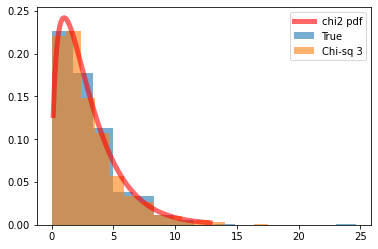

In [7]:
gen_data_ex = lambda : gen_data(nobs=1000, a=1.0, num_params=4)

llr_stats = plot_true2(gen_data_ex,setup_test)